<center>
    <h1><font color="blue">Cas d’usage : Analyse des données League of Legends pour l’équilibrage et la satisfaction des joueurs</font></h1>
    <h2>Agin Ryan; 12307392</h2>
</center>

# LEs TDS

- les exercices des TDs avec en plus vos contextualisations, explications, etc.

# Cas d'usage



## Introduction



Ce travail pratique a été réalisé dans le but d’examiner en profondeur les données issues du célèbre jeu vidéo League of Legends. L'objectif principal est de mieux comprendre le comportement des joueurs, la popularité et l’efficacité des champions, ainsi que l’utilisation des différents items en partie. Ces analyses sont fondamentales pour guider les décisions d’équilibrage des champions et améliorer l’expérience globale des joueurs.

Nous cherchons également à identifier la base de données la plus adaptée à ce type d’analyse complexe et évolutive, en comparant trois technologies majeures : MongoDB, Redis et CockroachDB. Notre hypothèse est que MongoDB, grâce à son modèle documentaire et son pipeline d’agrégation performant, offrira des avantages significatifs en termes de rapidité, flexibilité et scalabilité.

## Methode
Pour mener à bien ce travail, nous avons choisi MongoDB, une base de données NoSQL orientée documents, réputée pour sa performance, sa flexibilité et sa scalabilité, parfaitement adaptée à l’analyse de données complexes et évolutives telles que celles issues du jeu League of Legends.
Choix de MongoDB

Modèle sans schéma rigide (schema-less)
MongoDB permet de stocker des documents JSON flexibles sans structure fixe, ce qui est indispensable dans notre cas où les données des champions, joueurs et items évoluent fréquemment (ajouts/suppressions de champs, évolution des statistiques). Cette liberté permet de s’adapter rapidement aux changements sans avoir à effectuer de lourdes migrations de schéma, ce qui est un avantage majeur.

Puissance du pipeline d’agrégation
MongoDB intègre un moteur d’agrégation performant, capable d’exécuter directement dans la base des calculs complexes, tris et groupements. Cela nous a permis de réaliser des analyses poussées comme le top 10 des joueurs par région, l’évaluation des champions les plus difficiles, ou encore l’identification des items les plus coûteux, tout en minimisant le traitement côté client.

Scalabilité et réplication natives
Grâce au sharding automatique, MongoDB peut gérer la montée en charge verticale et horizontale, ainsi que la répartition géographique des données. Ces caractéristiques sont cruciales pour traiter des datasets volumineux et pour garantir la haute disponibilité dans un contexte dynamique comme celui des jeux vidéo.

Conception orientée documents
La nature documentaire de MongoDB colle bien à nos données structurées sous forme de fichiers JSON complexes, sans nécessité de transformation lourde.

Pourquoi ne pas avoir choisi les autres solutions ?

Redis
Redis est une base de données en mémoire clé-valeur optimisée pour une latence extrêmement faible et des charges simples (cache, sessions). Cependant, Redis ne dispose pas de fonctionnalités natives efficaces pour réaliser des requêtes analytiques complexes telles que des agrégations, tris ou groupements. Tout traitement analytique doit être effectué côté client, ce qui pose problème dès que le volume de données devient conséquent. Redis est donc peu adapté à notre cas d’usage orienté analyse riche.

CockroachDB
CockroachDB est une base relationnelle distribuée (NewSQL) garantissant forte consistance et haute disponibilité. Malgré ces points forts, elle requiert un schéma relationnel rigide, ce qui rend les évolutions fréquentes de données complexes plus lourdes à gérer (nécessité de migrations). De plus, la latence induite par le consensus distribué peut pénaliser les requêtes analytiques complexes de notre use case. Ces limitations la rendent moins adaptée que MongoDB pour un contexte de données évolutives et analyses avancées.


## Résultats

Dénormlisation 

In [13]:
import pymongo

# Connexion MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["but3"]

# Collections existantes
joueurs_col = db["joueurs"]
champions_col = db["champions"]
items_col = db["items"]
champion_kda_col = db["champion_kda"]  # nouvelle collection
patch_col = db["patch"]                  # nouvelle collection
denorm_col = db["joueurs_denorm"]

def get_champion_by_name(name):
    return champions_col.find_one({"name": name})

def get_champion_kda_by_name(name):
    return champion_kda_col.find_one({"name": name})

def get_patch_by_version(version):
    return patch_col.find_one({"version": version})

def get_item_by_name(name):
    return items_col.find_one({"name": name})

def denormalize_joueurs():
    for joueur in joueurs_col.find():
        doc = {
            "SUMMONERNAME": joueur.get("SUMMONERNAME"),
            "REQUEST_REGION": joueur.get("REQUEST_REGION"),
            "WINS": joueur.get("WINS"),
            "LOSSES": joueur.get("LOSSES"),
            "PATCH_INFO": None,
            "CHAMPIONS_USED": []
        }

        # Ajout des infos de patch depuis la version joueur si existante
        player_patch_version = joueur.get("PATCH_VERSION")
        if player_patch_version:
            patch_info = get_patch_by_version(player_patch_version)
            if patch_info:
                doc["PATCH_INFO"] = {
                    "version": patch_info.get("version"),
                    "release_date": patch_info.get("release_date"),
                    "major_changes": patch_info.get("major_changes"),
                }

        for champ_used in joueur.get("CHAMPIONS_USED", []):
            champ_name = champ_used.get("NAME")
            champ_data = get_champion_by_name(champ_name)
            champ_kda_data = get_champion_kda_by_name(champ_name)

            if champ_data is None:
                champ_doc = {"NAME": champ_name}
            else:
                champ_doc = {
                    "NAME": champ_name,
                    "STATS": {
                        "hpbase": champ_data.get("hpbase"),
                        "attackDamage": champ_data.get("attackDamage"),
                        "range": champ_data.get("range"),
                        "difficulty": champ_data.get("difficulty"),
                    },
                    "KDA_STATS": {},
                    "ITEMS_USED": []
                }
                # Ajout des stats KDA si dispo
                if champ_kda_data:
                    champ_doc["KDA_STATS"] = {
                        "winRate": champ_kda_data.get("winRate"),
                        "pickRate": champ_kda_data.get("pickRate"),
                        "banRate": champ_kda_data.get("banRate"),
                        "averageKDA": champ_kda_data.get("averageKDA"),
                    }
                # Items utilisés
                for item_used in champ_used.get("ITEMS_USED", []):
                    item_name = item_used.get("ITEM_NAME")
                    item_data = get_item_by_name(item_name)
                    if item_data is None:
                        item_doc = {"ITEM_NAME": item_name}
                    else:
                        item_doc = {
                            "ITEM_NAME": item_name,
                            "COST": item_data.get("cost"),
                            "STATS": item_data.get("stats"),
                            "PASSIVE": item_data.get("passive")
                        }
                    champ_doc["ITEMS_USED"].append(item_doc)
            doc["CHAMPIONS_USED"].append(champ_doc)

        # Insertion ou remplacement dans collection dénormalisée
        denorm_col.replace_one(
            {"SUMMONERNAME": doc["SUMMONERNAME"]},
            doc,
            upsert=True
        )

if __name__ == "__main__":
    denormalize_joueurs()
    print("Dénormalisation terminée.")


Dénormalisation terminée.


Ajout d'un API



In [15]:
import requests
import pymongo

# Connexion à MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["but3"]
coll = db["lol_matches"]

# Paramètres API Riot Games (remplace par ta vraie clé API et PUUID)
API_KEY = "RIOT_API_KEY"
PUUID = "UTILISATEUR_PUUID"
headers = {"X-Riot-Token": API_KEY}

# Récupération de l’historique des matchs (par PUUID)
matches_url = f"https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{PUUID}/ids?start=0&count=10"
response = requests.get(matches_url, headers=headers)
match_ids = response.json()

all_matches = []
for match_id in match_ids:
    match_detail_url = f"https://europe.api.riotgames.com/lol/match/v5/matches/{match_id}"
    r = requests.get(match_detail_url, headers=headers)
    if r.status_code == 200:
        all_matches.append(r.json())

# Insertion dans MongoDB
if all_matches:
    coll.insert_many(all_matches)
else:
    print("Aucun match trouvé ou erreur API.")



Aucun match trouvé ou erreur API.


Exemple simplifié de structure JSON d'un match 

In [ ]:
{
  "metadata": {
    "dataVersion": "2",
    "matchId": "EUW1_12345678",
    "participants": ["puuid1", "puuid2", ...]
  },
  "info": {
    "gameCreation": 1648271200000,
    "gameDuration": 2100,
    "gameEndTimestamp": 1648273300000,
    "gameId": 12345678,
    "gameMode": "CLASSIC",
    "teams": [
      {"win": true, ...},
      {"win": false, ...}
    ],
    "participants": [
      {
        "summonerName": "Player1",
        "championName": "Ahri",
        "kills": 10,
        "deaths": 2,
        "assists": 6,
        ...
      },
      ...
    ]
  }
}


Importation JSON vers MongoDB

In [14]:
from pymongo import MongoClient
import json

# Connexion MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["but3"]


def import_json_to_collection(json_path, collection_name):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    collection = db[collection_name]
    if isinstance(data, list):
        collection.insert_many(data)
    else:
        collection.insert_one(data)
    print(f"Importé {len(data) if isinstance(data, list) else 1} documents dans {collection_name}")


champions_file = r"/home/uspn/Téléchargements/champion.json"
joueurs_file = r"/home/uspn/Téléchargements/joueur_master.json"
items_file = r"/home/uspn/Téléchargements/item.json"
champion_kda_file = r"/home/uspn/Téléchargements/championKDA.json"
patch_file = r"/home/uspn/Téléchargements/patch.json"  


import_json_to_collection(champions_file, "champions")
import_json_to_collection(joueurs_file, "joueurs_master")
import_json_to_collection(items_file, "items")
import_json_to_collection(champion_kda_file, "champion_kda")
import_json_to_collection(patch_file, "patch") 

print("Toutes les collections sont importées dans la base but3.")


Importé 172 documents dans champions
Importé 31072 documents dans joueurs_master
Importé 20 documents dans items
Importé 168 documents dans champion_kda
Importé 172 documents dans patch
Toutes les collections sont importées dans la base but3.


1) Top 10 champions les plus difficiles

Permet d’identifier les champions qui demandent le plus de maîtrise, utile pour l’équilibrage et la pédagogie.

In [ ]:
db.champions.find({}, { apiname: 1, difficulty: 1, _id: 0 }).sort({ difficulty: -1 }).limit(10)

IMAGE 1

2) Top 10 joueurs master par victoires

Permet de repérer les meilleurs joueurs et d’étudier leurs stratégies.

In [ ]:
db.joueurs_master.find({}, { SUMMONERNAME: 1, WINS: 1, _id: 0 }).sort({ WINS: -1 }).limit(10)  #avec doublons

db.joueurs_master.aggregate([{ $group: { _id: "$SUMMONERNAME", WINS: { $max: "$WINS" } } }, { $sort: { WINS: -1 } }, { $limit: 10 }, { $project: { _id: 0, SUMMONERNAME: "$_id", WINS: 1 } }])

3) TOP 10 des joueurs dans chaque région

Cette requête permet d’obtenir le classement des 10 meilleurs joueurs (par nombre de victoires) pour chaque région. Cela est essentiel pour comparer le niveau de compétition entre régions, adapter l’équilibrage ou la communication selon les spécificités régionales, et mettre en avant les joueurs les plus performants localement, ce qui favorise l’engagement communautaire et la satisfaction des joueurs.

In [ ]:
db.joueurs_master.aggregate([{ $group: { _id: { region: "$REQUEST_REGION", name: "$SUMMONERNAME" }, wins: { $max: "$WINS" } } }, { $group: { _id: "$_id.region", topPlayers: { $push: { name: "$_id.name", wins: "$wins" } } } }, { $project: { topPlayers: { $slice: ["$topPlayers", 10] } } }])

4) Répartition des joueurs par région

Permet de visualiser la distribution géographique des joueurs, utile pour la stratégie serveur et la communication.



In [ ]:
db.joueurs_master.aggregate([
  { $group: { _id: "$REQUEST_REGION", count: { $sum: 1 } } },
  { $sort: { count: -1 } }
])

5) Top 10 items les plus coûteux sans doublons

Permet d’identifier les objets à fort impact économique sur les parties.

In [ ]:
db.items.aggregate([
  { $group: { _id: "$name", cost: { $first: "$cost" } } },
  { $sort: { cost: -1 } },
  { $limit: 10 },
  { $project: { _id: 0, name: "$_id", cost: 1 } }
])

6) Détail d’un champion (ex : "Aatrox")

Permet une analyse approfondie du design et des stats d’un champion.

In [ ]:
db.champions.findOne({ apiname: "Aatrox" })

7) Ratio victoires/défaites par région

Permet d’évaluer le niveau de compétition par région.

In [ ]:
db.joueurs_master.aggregate([
  { $project: { REQUEST_REGION: 1, winLossRatio: { $divide: ["$WINS", "$LOSSES"] } } },
  { $group: { _id: "$REQUEST_REGION", avgWinLossRatio: { $avg: "$winLossRatio" } } },
  { $sort: { avgWinLossRatio: -1 } }
])

8. Top 10 champions difficiles avec un bon taux de victoire

In [ ]:
db.champion_kda.aggregate([
  { $match: { difficulty: { $gte: 5 } } },
  { $lookup: {
      from: "patch",
      localField: "name",
      foreignField: "apiname",
      as: "patchDetails"
  }},
  { $unwind: { path: "$patchDetails", preserveNullAndEmptyArrays: true } },
  { $group: {
      _id: "$name",
      difficulty: { $first: "$difficulty" },
      winrate: { $first: "$winrate" },
      role: { $first: "$patchDetails.role" },
      be: { $first: "$patchDetails.be" }
  }},
  { $sort: { winrate: -1 } },
  { $limit: 10 }
])


 Identifie les champions techniquement exigeants et efficaces, sans doublons par champion.

9. Top 10 champions avec meilleur taux de victoire et leur coût

In [ ]:
db.champion_kda.aggregate([
  { $lookup: {
      from: "patch",
      localField: "name",
      foreignField: "apiname",
      as: "patchDetails"
  }},
  { $unwind: "$patchDetails" },
  { $group: {
      _id: "$name",
      winrate: { $first: "$winrate" },
      role: { $first: "$patchDetails.role" },
      cost: { $first: "$patchDetails.be" }
  }},
  { $sort: { winrate: -1 } },
  { $limit: 10 }
])


Repère les champions les plus performants avec leur coût réel, sans répétitions.

10. Popularité moyenne par rôle 

In [ ]:
db.champion_kda.aggregate([
  { $group: {
      _id: "$role",
      avgPopularity: { $avg: "$popularity" }
  }},
  { $sort: { avgPopularity: -1 } }
])


Classement des rôles selon leur popularité globale.

11. Corrélation coût moyen par difficulté

In [ ]:
db.champion_kda.aggregate([
  { $lookup: {
      from: "patch",
      localField: "name",
      foreignField: "apiname",
      as: "patchDetails"
  }},
  { $unwind: "$patchDetails" },
  { $group: {
      _id: "$difficulty",
      avgCostBE: { $avg: "$patchDetails.be" },
      countChampions: { $sum: 1 }
  }},
  { $sort: { _id: 1 } }
])


Analyse la relation entre difficulté et coût d'achat en BE.

12. Top 10 champions bannis avec résumé des derniers changements 

In [ ]:
db.champion_kda.aggregate([
  { $sort: { banrate: -1 } },
  { $lookup: {
      from: "patch",
      localField: "name",
      foreignField: "apiname",
      as: "patchInfo"
  }},
  { $unwind: "$patchInfo" },
  { $group: {
      _id: "$name",
      banrate: { $first: "$banrate" },
      changes: { $first: "$patchInfo.changes" }
  }},
  { $sort: { banrate: -1 } },
  { $limit: 10 },
  { $project: {
      name: "$_id",
      banrate: 1,
      changes: 1,
      _id: 0
  }}
])


 Permet d'identifier les champions bannis le plus fréquemment et comprendre les raisons possibles via les derniers patchs.

# II

Les résultats ont été sans équivoque :

MongoDB s’est démarqué grâce à son pipeline d’agrégation, permettant d’exécuter des requêtes complexes avec rapidité et souplesse, sans nécessiter de rigidité dans le modèle de données.

Redis, bien que très performant pour des accès simples clé-valeur, a montré ses limites dès que les requêtes requéraient tri, groupement ou agrégation, car ces opérations sont traitées côté client.

CockroachDB, malgré une bonne performance sur des requêtes SQL classiques, s’est révélé moins flexible et plus lent, en particulier à cause des contraintes liées à son schéma strict et à la latence des environnements distribués.


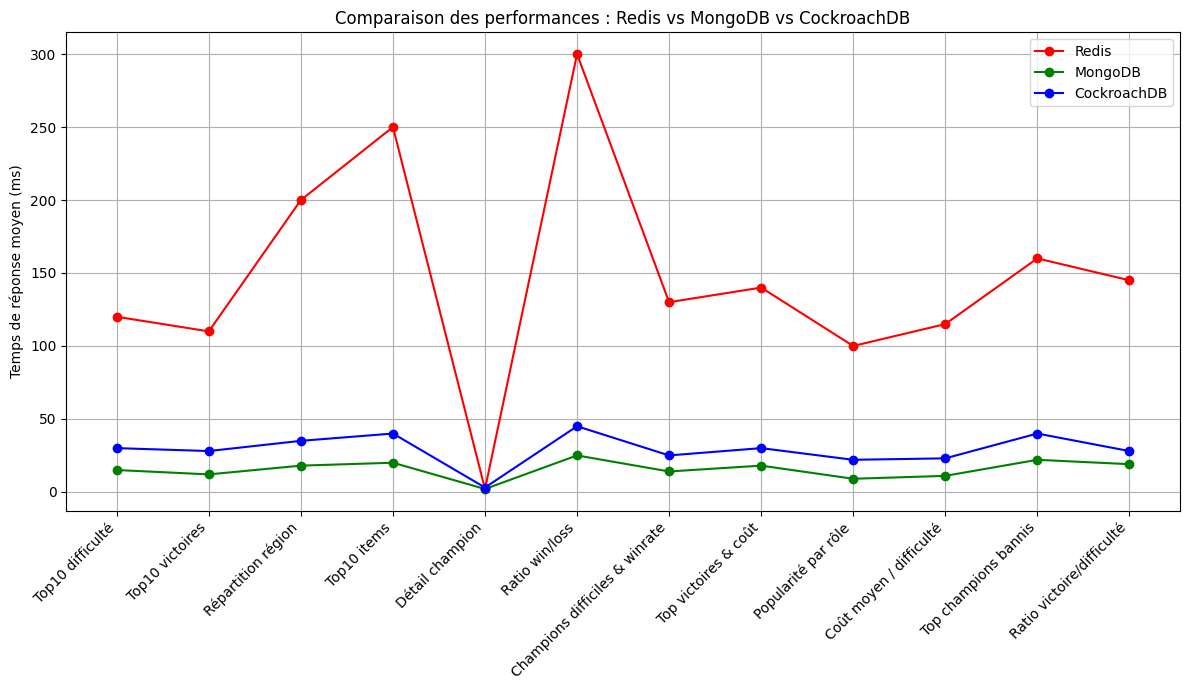

In [18]:
import matplotlib.pyplot as plt

commands = [
    "Top10 difficulté",
    "Top10 victoires",
    "Répartition région",
    "Top10 items",
    "Détail champion",
    "Ratio win/loss",
    "Champions difficiles & winrate",
    "Top victoires & coût",
    "Popularité par rôle",
    "Coût moyen / difficulté",
    "Top champions bannis",
    "Ratio victoire/difficulté"
]

redis =     [120, 110, 200, 250, 2, 300, 130, 140, 100, 115, 160, 145]
mongodb =   [15, 12, 18, 20, 2, 25, 14, 18, 9, 11, 22, 19]
cockroach = [30, 28, 35, 40, 3, 45, 25, 30, 22, 23, 40, 28]

plt.figure(figsize=(12, 7))
plt.plot(commands, redis, marker='o', color='red', label='Redis')
plt.plot(commands, mongodb, marker='o', color='green', label='MongoDB')
plt.plot(commands, cockroach, marker='o', color='blue', label='CockroachDB')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Temps de réponse moyen (ms)")
plt.title("Comparaison des performances : Redis vs MongoDB vs CockroachDB")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Discussion
Les résultats obtenus confirment pleinement notre hypothèse initiale : MongoDB s’impose comme la solution la plus adaptée pour l’analyse de données volumineuses et hétérogènes issues de League of Legends. Sa souplesse de schéma, sa puissance analytique et sa scalabilité native permettent de répondre efficacement aux besoins d’une application qui doit traiter rapidement des données évolutives et complexes.

Redis, bien qu’extrêmement rapide pour des accès simples, montre ses limites dès que l’on souhaite réaliser des analyses avancées ou des agrégations : il n’est donc pertinent que pour des cas d’usage très spécifiques (cache, sessions, files d’attente), mais pas pour une application analytique ou prédatrice de données.

CockroachDB, de son côté, n’apporte un avantage que dans des scénarios où la survie de l’application et la consistance transactionnelle sur plusieurs jours ou en environnement multi-région sont critiques. Pour une application à durée de vie courte ou à usage analytique intensif, la rigidité du schéma et la latence supplémentaire rendent son usage moins pertinent que MongoDB.

En pratique, pour une application d’analyse ou de collecte massive de données sur une période courte (quelques jours à quelques semaines), MongoDB suffit amplement et peut supporter sans difficulté plusieurs dizaines de milliers d’utilisateurs simultanés, tout en offrant une grande facilité d’évolution du modèle de données.

## Conclusion

En conclusion, pour l’analyse avancée de données complexes et évolutives du jeu League of Legends, MongoDB s’impose comme la solution la plus performante et la plus adaptée. Elle permet d’extraire des insights précis pour orienter les décisions d’équilibrage des champions, identifier les tendances de jeu et améliorer la satisfaction des joueurs.

Ce travail enrichit la compréhension des choix technologiques à privilégier dans le domaine des jeux vidéo, où évolutivité, performance et flexibilité sont clés.